# Matrix Factorization
https://petamind.com/build-a-simple-recommender-system-with-matrix-factorization/

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm.autonotebook as tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras

from movie_helper.movie import load_movies
from movie_helper.rating import load_ratings

In [27]:
ratings = load_ratings()
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [28]:
# ID starts from 0
ratings.user_id = ratings.user_id.astype("category").cat.codes.values
ratings.item_id = ratings.item_id.astype("category").cat.codes.values

In [29]:
ratings.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [7]:
train, test = train_test_split(ratings, test_size=0.2)
train.shape, test.shape

((80000, 4), (20000, 4))

In [8]:
n_users, n_movies = len(ratings.user_id.unique()), len(ratings.item_id.unique())
n_latent_factors = 20

In [10]:
movie_input = keras.layers.Input(shape=[1], name="Item")
movie_embedding = keras.layers.Embedding(
    n_movies + 1, n_latent_factors, name="Movie-Embedding"
)(movie_input)
movie_vec = keras.layers.Flatten(name="FlattenMovies")(movie_embedding)

user_input = keras.layers.Input(shape=[1], name="User")
user_vec = keras.layers.Flatten(name="FlattenUsers")(
    keras.layers.Embedding(n_users + 1, n_latent_factors, name="User-Embedding")(
        user_input
    )
)
prod = keras.layers.dot([movie_vec, user_vec], axes=1, name="DotProduct")
model = keras.Model([user_input, movie_input], prod)

In [11]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae", "mse"])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 20)                33660     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 20)                18880     ['User[0][0]']            

In [14]:
tf.keras.utils.plot_model(model, to_file="model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [39]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=1)

Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.5683 - mae: 0.5886 - mse: 0.5683
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.5419 - mae: 0.5736 - mse: 0.5419
Epoch 3/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.5166 - mae: 0.5598 - mse: 0.5166
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4944 - mae: 0.5467 - mse: 0.4944
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.4755 - mae: 0.5358 - mse: 0.4755
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.4585 - mae: 0.5247 - mse: 0.4585
Epoch 7/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.4437 - mae: 0.5162 - mse: 0.4437
Epoch 8/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4307 - mae: 0.5079 - mse: 0.4307
Epoch 9/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.4188 - mae: 0.5000 - mse: 0.4188
E

Text(0, 0.5, 'Training Error')

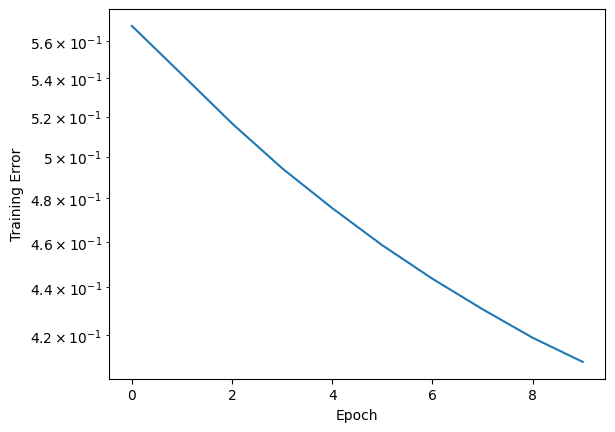

In [40]:
pd.Series(history.history["loss"]).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [42]:
results = model.evaluate((test.user_id, test.item_id), test.rating, batch_size=32)

625/625 [==============================] - 1s 2ms/step - loss: 1.0233 - mae: 0.7877 - mse: 1.0233


In [43]:
movie_embedding_learnt = model.get_layer(name="Movie-Embedding").get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000
mean,0.355577,-0.374898,0.381258,0.355945,-0.345298,0.357012,-0.360232,0.338207,0.349363,-0.364580,-0.350724,-0.354714,-0.359871,-0.364750,-0.364418,-0.335376,0.341497,0.364001,0.340281,0.344957
std,0.265441,0.331087,0.291934,0.364911,0.401071,0.249204,0.270044,0.323960,0.270068,0.326940,0.297491,0.264193,0.276770,0.263696,0.294172,0.352381,0.318108,0.283627,0.319159,0.269212
min,-0.579942,-1.479557,-0.741593,-1.173248,-1.943867,-0.408374,-1.392387,-0.919161,-0.611975,-1.511046,-1.389072,-1.390916,-1.270551,-1.373782,-1.571352,-1.610240,-1.012083,-0.786071,-1.002625,-0.496500
25%,0.189836,-0.586884,0.185220,0.130138,-0.604551,0.197687,-0.514152,0.118702,0.171184,-0.570390,-0.533945,-0.515660,-0.532186,-0.531131,-0.542586,-0.571869,0.149299,0.176063,0.136076,0.176061
50%,0.340875,-0.373140,0.384412,0.364112,-0.355398,0.352920,-0.345089,0.337416,0.336925,-0.365527,-0.349720,-0.351643,-0.365525,-0.363273,-0.365305,-0.345382,0.359508,0.359328,0.351862,0.342327
75%,0.508361,-0.158895,0.561113,0.600259,-0.076201,0.508674,-0.183169,0.558979,0.510118,-0.158903,-0.161870,-0.184549,-0.177758,-0.187008,-0.176394,-0.104160,0.536861,0.545357,0.535451,0.503306
max,1.464826,0.916364,1.366298,1.603170,0.929988,1.201510,0.567339,1.497217,1.440023,1.107196,0.854582,0.507454,0.499430,0.586958,0.899766,0.721929,1.765647,1.249691,1.683770,1.469857


In [44]:
user_embedding_learnt = model.get_layer(name="User-Embedding").get_weights()[0]

In [45]:
def recommend(user_id, number_of_movies=5):
    movies = user_embedding_learnt[user_id] @ movie_embedding_learnt.T
    mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
    return mids

In [68]:
user_id = 10
recommend(user_id=user_id, number_of_movies=10)

array([ 301,  922,  935, 1449,  458,  271, 1393, 1466, 1499, 1367])

In [69]:
movies = load_movies()


def get_movies_by_user_ids(user_ids):
    return movies[movies.movie_id.isin(user_ids)]

In [71]:
get_movies_by_user_ids(recommend(user_id=user_id, number_of_movies=10))

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
270,271,Starship Troopers (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Starship+Troo...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0
300,301,In & Out (1997),19-Sep-1997,NaN,http://us.imdb.com/Title?In+%26+Out+(1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
457,458,Nixon (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Nixon%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
921,922,Dead Man (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
934,935,Paradise Road (1997),18-Apr-1997,NaN,http://us.imdb.com/M/title-exact?Paradise%20Ro...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1366,1367,Faust (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1392,1393,Stag (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Stag+(1997),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1448,1449,Pather Panchali (1955),22-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Pather%20Panc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1465,1466,Margaret's Museum (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Margaret's%20...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,1499,Grosse Fatigue (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Grosse%20fati...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
get_movies_by_user_ids(
    ratings.query(f"user_id == {user_id}")
    .sort_values("rating", ascending=False)
    .head(10)
    .item_id.values
)

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
26,27,Bad Boys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Bad%20Boys%20...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,195,"Terminator, The (1984)",01-Jan-1984,NaN,"http://us.imdb.com/M/title-exact?Terminator,%2...",0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
330,331,"Edge, The (1997)",26-Sep-1997,NaN,http://us.imdb.com/M/title-exact?Edge%2C+The+(...,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
421,422,Aladdin and the King of Thieves (1996),01-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Aladdin%20and...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
427,428,Harold and Maude (1971),01-Jan-1971,NaN,http://us.imdb.com/M/title-exact?Harold%20and%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
657,658,Pump Up the Volume (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Pump%20Up%20t...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
705,706,Bad Moon (1996),01-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Bad%20Moon%20...,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
743,744,Michael Collins (1996),11-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Michael%20Col...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
747,748,"Saint, The (1997)",14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Saint%2C%20Th...,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
748,749,"MatchMaker, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Matchmaker%2C...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
